In [1]:
import mujoco
import mediapy as media
from dm_control import mjcf
import numpy as np
from robot_descriptions.z1_mj_description import MJCF_PATH
from utils import update_actuator, ActuatorMotor

# np.random.seed(0)

In [2]:
print(MJCF_PATH)

/home/simeon/.cache/robot_descriptions/mujoco_menagerie/unitree_z1/z1.xml


In [3]:
# load the model
mjcf_model = mjcf.from_path(MJCF_PATH)
# append the body to the end-effector
ee_body = mjcf_model.find("body", "link06")

ee_body

MJCF Element: <body name="link06" pos="0.049200000000000001 0 0">...</body>

In [4]:
# old model
old_model = mujoco.MjModel.from_xml_path(MJCF_PATH)
old_data = mujoco.MjData(old_model)
body_offset = np.where(old_model.body_dofadr == 0)[0][0]

# create new body
rc = np.array([0.05, 0.1, -0.08])
load_mass = ee_body.add("body", name="load_mass", pos=f"{rc[0]} {rc[1]} {rc[2]}")
load_mass.add(
    "geom", name="load_mass_geom", type="sphere", size="0.05", rgba="0.8 0.2 0.2 1", conaffinity = '0', contype = '0'
)

M = 0.5
# R = 0.0001
I = 1e-3#M * rc[0]**2

load_mass.add("inertial", mass=f"{M}", pos=f"0 0 0", diaginertia=f"{1e-3} {1e-3} {1e-3}")

for geom in mjcf_model.find_all("geom"):
    geom.conaffinity = 0
    geom.contype = 0


physics = mjcf.Physics.from_mjcf_model(mjcf_model)
sim_model = physics.model._model
sim_data = mujoco.MjData(sim_model)
renderer = mujoco.Renderer(sim_model, height=480, width=640)

""

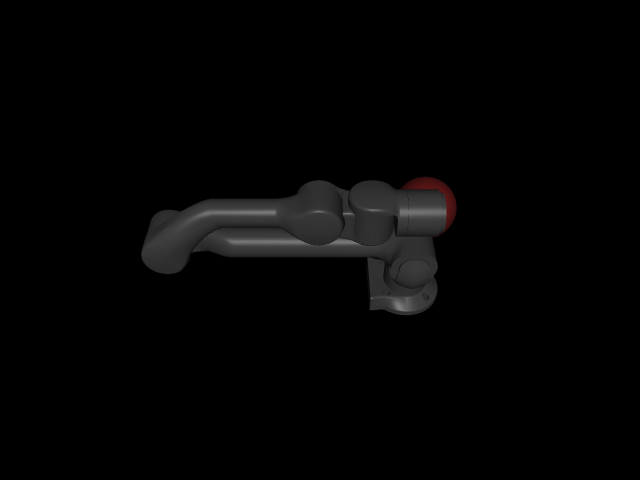

In [5]:
# Reset data, set initial pose.
mujoco.mj_resetData(sim_model, sim_data)

# Step the simulation.
mujoco.mj_step(sim_model, sim_data)

renderer.update_scene(sim_data)
media.show_image(renderer.render())

In [6]:
def staticload_joint_regressor(mj_model, mj_data, ee_id, active_joints = 7, body_offset = 0):

    accel = np.zeros(6)

    mujoco.mj_rnePostConstraint(mj_model, mj_data)
    mujoco.mj_objectAcceleration(mj_model, mj_data, 2, ee_id, accel, 1)
    rotation = mj_data.xmat[ee_id+body_offset].reshape(3, 3).copy()

    a1, a2, a3 = rotation.T @ np.array([0,0,9.81]) #

    static_load_regressor = np.array([[a1, 0, 0, 0],
                                      [a2, 0, 0, 0],
                                      [a3, 0, 0, 0],
                                      [0, 0, a3, -a2],
                                      [0, -a3, 0, a1],
                                      [0, a2, -a1, 0]])
    
    jac_lin = np.zeros((3, mj_model.nv))
    jac_rot = np.zeros((3, mj_model.nv))
    mujoco.mj_jacBody(mj_model, mj_data, jac_lin, jac_rot, ee_id + body_offset)
    ee_local_jacobian = np.vstack((rotation.T@jac_lin[:, :active_joints],
                                   rotation.T@jac_rot[:, :active_joints]))
    joint_regressor = ee_local_jacobian.T @ static_load_regressor
    
    return joint_regressor

In [7]:
for actuator_id in range(sim_model.nu):
    actuator = ActuatorMotor()
    update_actuator(sim_model, actuator_id, actuator)

# find limits except the last two fingers
lower, upper = np.zeros(sim_model.nq), np.zeros(sim_model.nq)
for jnt_idx in range(sim_model.nq):
    lower[jnt_idx] = sim_model.joint(jnt_idx).range[0]
    upper[jnt_idx] = sim_model.joint(jnt_idx).range[1]

kp = 60
kd = 20
target_q = np.random.uniform(lower, upper)

frames = []
framerate = 25

phase_time = 5.0
num_of_phases = 30
phases = 0
old_data.time = 0 
sim_data.time = 0

# print(sim_model.nq)
load_joint_regressor = np.zeros((sim_model.nq*num_of_phases, 4))
load_joint_force = np.zeros((sim_model.nq*num_of_phases))
active_joints = sim_model.nq

while sim_data.time < num_of_phases*phase_time:
    # PD controller
    mujoco.mj_step(sim_model, sim_data)

    target_acc = kp * (target_q - sim_data.qpos) + kd * (
        np.zeros(sim_model.nv) - sim_data.qvel
    )

    # use old data to solve inverse dynamics
    old_data.qpos = sim_data.qpos.copy()
    old_data.qvel = sim_data.qvel.copy()
    old_data.qacc = target_acc
    mujoco.mj_inverse(old_model, old_data)
    sol = old_data.qfrc_inverse

    sim_data.ctrl = sol
    # regressor = staticload_joint_regressor(old_model, old_data, old_data.body(ee_body.name).id).copy()
    # sim_data.ctrl += regressor@np.array([M,*(M*rc)])
    
    if sim_data.time > phase_time * phases and sim_data.time < num_of_phases*phase_time: 
        # print(load_force)
        regressor = staticload_joint_regressor(old_model, old_data, old_data.body(ee_body.name).id).copy()
        load_joint_regressor[6*phases: 6*(phases+1), :] = regressor
        
        load_qforce = sol - old_data.qfrc_bias
        load_joint_force[6*phases: 6*(phases+1)] = load_qforce.copy()
        actual_load_qforce = regressor@np.array([M,*(M*rc)])
        # print(load_qforce)
        print((target_q - sim_data.qpos))
        
        phases += 1
        target_q = np.random.uniform(lower, upper)
        
         
    
#     if len(frames) < sim_data.time * framerate:
#         renderer.update_scene(sim_data)
#         frames.append(renderer.render())
        

# media.show_video(frames, fps=framerate)

[ 2.26752368  0.92272196 -2.79178578 -1.32704817 -0.56291787 -1.2106281 ]
[-0.04740257 -0.08664958 -0.14428079  0.13801779  0.43291723  2.42688908]
[ 0.00469786 -0.0679554  -0.19482254  0.39100853  0.11598775  2.7582738 ]
[ 0.03742377 -0.10085902 -0.08606014  0.41335272 -1.31936703  2.7533667 ]
[-0.00791242 -0.0522241   0.22617167  0.85356223 -0.34484114  0.98990139]
[ 0.00800224 -0.01710229 -0.12449761 -0.23074342 -0.14942584  1.48211891]
[ 0.01791175 -0.01392674 -0.11650445 -0.31148704 -0.33540605 -0.17664892]
[-0.00420827  0.00923258 -0.0989399  -0.59418655 -0.20442948  0.95818437]
[ 0.00399685  0.01996776 -0.13136566 -0.37017165  0.07993334  1.94558408]
[ 0.00974099 -0.07894898 -0.07149366  0.55541919 -0.17153942 -0.02928745]
[-0.01547083 -0.087185   -0.10085854  0.02686237  0.19487993  2.08352134]
[-0.0299012  -0.12864857  0.04840124  0.02741366  0.90471055 -1.99106457]
[ 8.20209253e-04  3.12059785e-03  7.22211962e-02 -1.38267434e+00
  3.13194873e-02 -1.18343194e+00]
[-0.01152119 

In [8]:
params_estimates = np.linalg.pinv(load_joint_regressor[6:,:])@load_joint_force[6:]
mass = params_estimates[0]
coordinate = params_estimates[1:]/mass
mass, coordinate

(0.5030792646188526, array([ 0.02105481,  0.05668482, -0.04849828]))

In [9]:
import mujoco.minimize as minimize

result = minimize.least_squares(
    np.ones(4),
    lambda x: (load_joint_regressor[6:] @ x - load_joint_force[6:]) ** 2,
)
estimates = result[0]
mass = estimates[0]
coordinate = estimates[1:]/mass
mass, coordinate

iter: 0    y: 1.848e+06  log10mu: -inf  ratio: 0.94     dx: 0.9      reduction: 1.7e+06
iter: 1    y: 1.161e+05  log10mu: -inf  ratio: 0.94     dx: 0.45     reduction: 1.1e+05
iter: 2    y: 7415       log10mu: -inf  ratio: 0.94     dx: 0.23     reduction: 6.9e+03
iter: 3    y: 512        log10mu: -inf  ratio: 0.95     dx: 0.12     reduction: 4.6e+02
iter: 4    y: 51.33      log10mu: -inf  ratio: 0.96     dx: 0.065    reduction: 36     
iter: 5    y: 15.53      log10mu: -inf  ratio: 0.88     dx: 0.041    reduction: 2.8    
iter: 6    y: 12.77      log10mu: -inf  ratio: 0.92     dx: 0.024    reduction: 0.15   
iter: 7    y: 12.62      log10mu: -inf  ratio: 0.64     dx: 0.01     reduction: 0.0069 
iter: 8    y: 12.61      log10mu: -inf  ratio: 0.53     dx: 0.0042   reduction: 0.00079
iter: 9    y: 12.61      log10mu: -inf  ratio: 0.49     dx: 0.0019   reduction: 0.00016
iter: 10   y: 12.61      log10mu: -inf  ratio: 0.51     dx: 0.00099  reduction: 4.2e-05
iter: 11   y: 12.61      log10mu

(0.49890536814525294, array([ 0.0169209 ,  0.0312285 , -0.04748689]))

In [10]:
for i in range(len(target_q)):
    print(f"joint {i} target: {target_q[i]:.2f} actual: {sim_data.qpos[i]:.2f}")

joint 0 target: -2.06 actual: -2.06
joint 1 target: 0.75 actual: 0.63
joint 2 target: -2.39 actual: -2.07
joint 3 target: 1.50 actual: 1.52
joint 4 target: 0.17 actual: 0.18
joint 5 target: 2.39 actual: -0.86
